The purpose of this investigation is to demonstrate the effects of $\color{blue}{\alpha_1}$ and $\color{red}{\alpha_2}$ on the potential connectivity of a landscape with a fixed covariate surface.

Potential connectivity is given by sum of use probabilities:

$$C^P(i) = \sum_{j} Pr(g[i,j])$$ 
$$ Pr(g[i,j]) = e^{-\color{blue}{\alpha_1} d_{ecol}(i,j)^2}
= \left( e^{d_{ecol}(i,j)^2} \right)^{-\color{blue}{\alpha_1}}
= \left( e^{d_{ecol}(i,j)^2} \right)^{-\color{blue}{\frac{1}{2\sigma^2}}}$$

So, **$\alpha_1$ modulates the rate at which ecological distance causes use probabilities to decay**; larger $\alpha_1$ values lead to a more rapid decay. This is like an animal species that is less willing to move through large ecological distances.

Ecological distance is given by:

$$d_{ecol}(i,j) = min_{\mathcal{L}} \sum_{p=1}^{m+1} cost(v_p,v_{p+1}) d_{euc}(v_p, v_{p+1}) 
= min_{\mathcal{L}} \sum_{p=1}^{m+1} e^{\alpha_2 \frac{z(v_p) + z(v_{p+1})}{2}} d_{euc}(v_p, v_{p+1}) 
= min_{\mathcal{L}} \sum_{p=1}^{m+1} \left(e^{\frac{z(v_p) + z(v_{p+1})}{2}}\right)^{\color{red}{\alpha_2}} d_{euc}(v_p, v_{p+1})$$

Therefore, **$\alpha_2$ modulates the extent to which the landscape covariate increases the ecological distance**. In our current experiments, high covariate values represent high resistance to movement and poor habitat, so larger $\alpha_2$ values lead to a stronger dependence of ecological distance on covariate values. This is like an animal species whose movement is highly affected by the covariate surface. $\alpha_2=0$ reduces to the case of using Euclidean distance.

Both higher $\color{blue}{\alpha_1}$ and $\color{red}{\alpha_2}$ work to reduce the use probabilities $Pr(g[i,j])$. Hence, an increase in $\color{red}{\alpha_2}$ can be counteracted by a decrease in $\color{blue}{\alpha_1}$, which is precisely the mechanism used to maintain home ranges at a constant size under the two $\color{red}{\alpha_2}$ settings. For example, when an animal species's movement is highly affected by (sensitive to) the covariate surface (high $\alpha_2$), precicted ecological distances will be higher than Euclidean, but to keep home range size constant we will choose low $\alpha_1$ to make the species less sensitive to ecological distances overall. First, let us check whether the home ranges are indeed about the same size for both settings.

>I proceed by using a single covariate surface and computing the use probabilities under the two different $(\alpha_1, \alpha_2)$ scenarios. The target home range size is 64 pixels. I computed the $\alpha_1$ value for each resistance setting using the corresponding effective sigma values taken from Dana's manuscript:
$$\alpha_2 = 0.25 \implies \sigma_{effective} = 0.1677509 \implies \alpha_1 = 17.76807123$$
$$\alpha_2 = 1.75 \implies \sigma_{effective} = 0.3749552 \implies \alpha_1 = 3.55640524856$$
Given the covariate surface, I compute the $d_{ecol}(i,j)$ (least-cost shortest paths) under each setting. (Note, I do not know what order of magnitude the $d_{euc}(v_p, v_{p+1})$ distances actually are; I set the distance between horizontally/vertically adjacent pixels to be $0.1$ units, so the distance between diagonally adjacent pixels is $\sqrt{(0.1)^2+(0.1)^2}$ units and the distance between the neighbors from the 16-pixel neighborhood is $\sqrt{(0.1)^2+(0.2)^2}$; this gives me use probability values that are comparable to the values in the potmat matrices I am working with.)

In [1]:
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import rasterio
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

def compute_ecological_distances(landscape, a2):
    # computes the ecological distance between every pair of pixels in a landscape
    # inputs:    landscape    -    covariate values
    #            a2           -    alpha2
    # outputs:   apsp        -    all pairs shortest path lengths
    nrow = len(landscape)
    ncol = len(landscape[0])
    
    print("Computing the ecological distances for %s-by-%s covariate surface %s.\na2 = %s"%(nrow,ncol,covariatedatafilename,a2))
    
    # create the graph
    nodes = [_ for _ in range(nrow*ncol)]
    #pos = [] # positions for visualizing using nx.draw()
    graph = nx.Graph()
    pix_length = 0.1
    edge_length = {4: 0, 8: 0, 16: 0}
    edge_length[4] = pix_length
    edge_length[8] = math.sqrt(pix_length**2 + pix_length**2)
    edge_length[16] = math.sqrt(pix_length**2 + (2*pix_length)**2)
    for n in nodes:
        graph.add_node(n)
        col = n/ncol
        row = n%ncol
        #pos.append((row, col))
    for r in range(nrow-1):
        for c in range(ncol):
            # north edges across rows # 4-neighborhood
            graph.add_edge(r*ncol + c, (r+1)*ncol + c, weight=edge_length[4]*math.exp(a2*(landscape[r][c]+landscape[r+1][c])/2))
        for c in range(ncol-1):
            # north-east edges across rows (row and col increasing) # 8-neighborhood
            graph.add_edge(r*ncol + c, (r+1)*ncol + c + 1, weight=edge_length[8]*math.exp(a2*(landscape[r][c]+landscape[r+1][c+1])/2))
        for c in range(ncol-2):
            # east-north-east edge # 16-neighborhood
            graph.add_edge(r*ncol + c, (r+1)*ncol + c + 2, weight=edge_length[16]*math.exp(a2*(landscape[r][c]+landscape[r+1][c+2])/2))
    for r in range(nrow-2):
        for c in range(ncol-1):
            # north-north-east edge # 16-neighborhood
            graph.add_edge(r*ncol + c, (r+2)*ncol + c + 1, weight=edge_length[16]*math.exp(a2*(landscape[r][c]+landscape[r+2][c+1])/2))
    for c in range(ncol-1):
        for r in range(nrow):
            # horizontal edges across columns # 4-neighborhood
            graph.add_edge(r*ncol + c, r*ncol + c + 1, weight=edge_length[4]*math.exp(a2*(landscape[r][c]+landscape[r][c+1])/2))
        for r in range(1,nrow):
            # diagonal edges across rows (row decreasing col increasing) # 8-neighborhood
            graph.add_edge(r*ncol + c, (r-1)*ncol + c + 1, weight=edge_length[8]*math.exp(a2*(landscape[r][c]+landscape[r-1][c+1])/2))
        for r in range(2,nrow):
            # south-south-east edge # 16-neighborhood
            graph.add_edge(r*ncol + c, (r-2)*ncol + c + 1, weight=edge_length[16]*math.exp(a2*(landscape[r][c]+landscape[r-2][c+1])/2))
    for c in range(ncol-2):
        for r in range(1,nrow):
            # east-south-east edge # 16-neighborhood
            graph.add_edge(r*ncol + c, (r-1)*ncol + c + 2, weight=edge_length[16]*math.exp(a2*(landscape[r][c]+landscape[r-1][c+2])/2))
    graph = graph.to_undirected()
    
    # compute all pair shortest paths
    apsp = nx.all_pairs_dijkstra_path_length(graph)
    #print("Finished computing all pairs shortest paths.")
    return apsp

def compute_use_probabilities(ecological_distance, es, a0 = 1):
    # given ecological distances for a landscape, computes the use probabilities
    # inputs:    ecological_distance     -    computed pairwise ecological distances
    #            es                      -    effective sigma used to compute
    #            a0                      -    alpha0 detection probability, default value 1
    # outputs:   useprobs                -    all pairs shortest path lengths
    print("a0 = %s"%(a0))
    a1 = 1/(2*es*es)
    print("a1 = %s (es = %s)"%(a1, es))
    npix = len(ecological_distance)
    useprobs = np.zeros((npix, npix))
    for j in range(npix):
        for i in range(npix):
            d = ecological_distance[i][j]
            useprobs[i][j] = a0*(math.exp(-(d*d)))**a1
    return useprobs

def compute_potential_connectivities(use_probs):
    # given use probabilities for a landscape, computes the potential connectivity for each pixel
    # inputs:    use_probs     -    computed pairwise use probabilities
    # outputs:   pc            -    potential connectivity values
    npix = len(use_probs)
    pc = np.zeros(npix)
    for j in range(npix):
        jsum = 0
        for i in range(npix):
            jsum = jsum + use_probs[i][j]
        pc[j] = jsum
    return(pc)

In [2]:
# covariatedatafilename = "../../Documents/LandscapeConnectivity/scropt/data/simcov_a2025_S100_cov.tif"
covariatedatafilename = "../../Desktop/hropt/Data/simcov_a2025_S100_cov.tif"
covariatesurfacedata = rasterio.open(covariatedatafilename)
covariatesurface = covariatesurfacedata.read().squeeze()

npix = 1600
alpha2 = [0.25, 1.75]
effsig = [0.1677509, 0.3749552]
decol = dict()
useprobs = dict()
pc = dict()
for a2idx in range(len(alpha2)):
    decol[alpha2[a2idx]] = compute_ecological_distances(covariatesurface,alpha2[a2idx])
    useprobs[alpha2[a2idx]] = compute_use_probabilities(decol[alpha2[a2idx]], effsig[a2idx])
    pc[alpha2[a2idx]] = compute_potential_connectivities(useprobs[alpha2[a2idx]])

Computing the ecological distances for 40-by-40 covariate surface ../../Desktop/hropt/Data/simcov_a2025_S100_cov.tif.
a2 = 0.25
a0 = 1
a1 = 17.76807123 (es = 0.1677509)
Computing the ecological distances for 40-by-40 covariate surface ../../Desktop/hropt/Data/simcov_a2025_S100_cov.tif.
a2 = 1.75
a0 = 1
a1 = 3.55640524856 (es = 0.3749552)


a2: 0.25    theta: 0.1677509    min HR: 20    max HR: 69    mean HR: 57.5775
a2: 1.75    theta: 0.3749552    min HR: 11    max HR: 114    mean HR: 60.98125


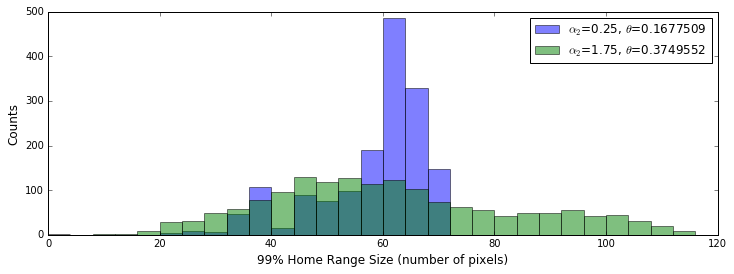

a2: 0.25    theta: 0.1677509    min d_ecol: 0    max d_ecol: 6.31034525251    mean d_ecol: 2.40952483994
a2: 1.75    theta: 0.3749552    min d_ecol: 0    max d_ecol: 13.1717733578    mean d_ecol: 5.07698087308


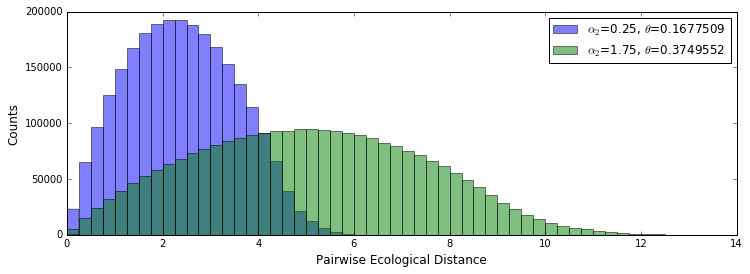

In [3]:
plt.figure(figsize = (12,4))
hrsize = dict()
bin_boundaries = np.linspace(0,120,31)
# print(bin_boundaries)
for a2idx in range(len(alpha2)):
    hrsize[alpha2[a2idx]] = []
    potmat = useprobs[alpha2[a2idx]]
    low = potmat < 0.01
    potmat[low] = 0
#     print("--------")
    for p in range(1600):
        hrsize[alpha2[a2idx]].append((potmat[p,]!=0).sum())
#         if hrsize[alpha2[a2idx]][-1] > 110:
#             print p
    print("a2: %s    theta: %s    min HR: %s    max HR: %s    mean HR: %s"%(alpha2[a2idx], effsig[a2idx], min(hrsize[alpha2[a2idx]]), max(hrsize[alpha2[a2idx]]), np.mean(hrsize[alpha2[a2idx]])))
    n, bins, patches = plt.hist(hrsize[alpha2[a2idx]], bins=bin_boundaries, alpha=0.5)
plt.ylabel("Counts", fontsize=12)
plt.xlabel("99% Home Range Size (number of pixels)", fontsize=12)
plt.legend([r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[0], effsig[0]), r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[1], effsig[1])])
plt.show()

plt.figure(figsize = (12,4))
decolvals = dict()
bin_boundaries = np.linspace(0,14,57)
# print(bin_boundaries)
for a2idx in range(len(alpha2)):
    decolvals[alpha2[a2idx]] = []
    for i in range(1600):
        for j in range(1600):
            decolvals[alpha2[a2idx]].append(decol[alpha2[a2idx]][i][j])
    print("a2: %s    theta: %s    min d_ecol: %s    max d_ecol: %s    mean d_ecol: %s"%(alpha2[a2idx], effsig[a2idx], min(decolvals[alpha2[a2idx]]), max(decolvals[alpha2[a2idx]]), np.mean(decolvals[alpha2[a2idx]])))
    n, bins, patches = plt.hist(decolvals[alpha2[a2idx]], bins=bin_boundaries, alpha=0.5)
plt.ylabel("Counts", fontsize=12)
plt.xlabel("Pairwise Ecological Distance", fontsize=12)
plt.legend([r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[0], effsig[0]), r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[1], effsig[1])])
plt.show()

Note, here we are showing the 99% home range sizes, which agree better with the target home range size of 63.4 pixels (based on manuscript appendix). For the optimization experiments we ran before, we used the 95% home range. The mean 99% home range size for $(\alpha_2=0.25, \theta=0.1677509)$ was 57.5775 (versus 60.11 reported in manuscript for this setting); the mean for $(\alpha_2=1.75, \theta=0.3749552)$ was 60.98125 (versus 60.45 reported). Hence the latter setting has slightly larger home ranges on average. The more prominent difference between the settings in terms of home range size is in their variability. For $(\alpha_2=0.25, \theta=0.1677509)$, home ranges were in the range [20, 69] (reported [53, 64]) while for $(\alpha_2=1.75, \theta=0.3749552)$ they were in the range [11, 114] (reported [23, 91]). Hence we have greater variability in the home range sizes (or use probabilities) in the high resistance setting, which is most likely due to the greater variability in ecological distances.

We examine a handful of home ranges located in low-covariate (good) and high-covariate (bad) areas:

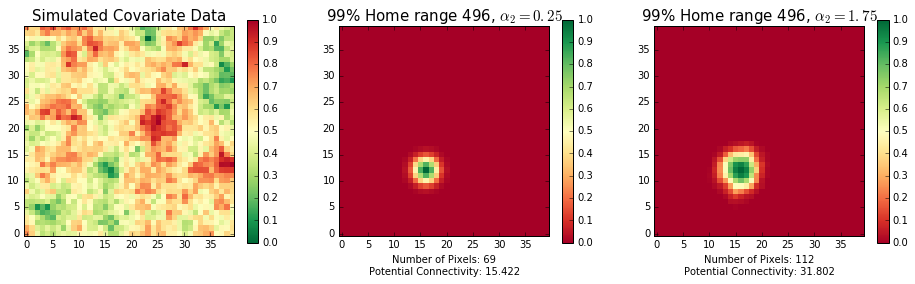

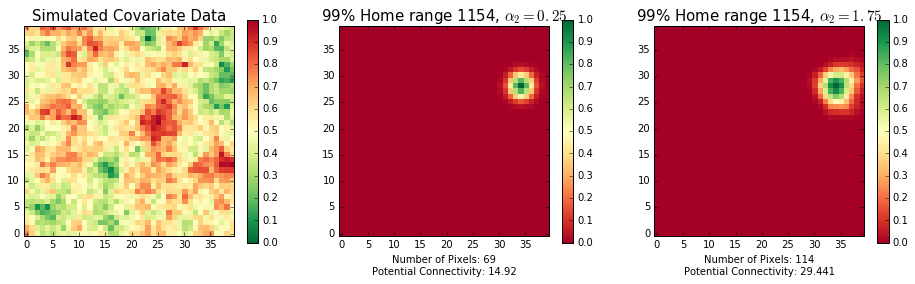

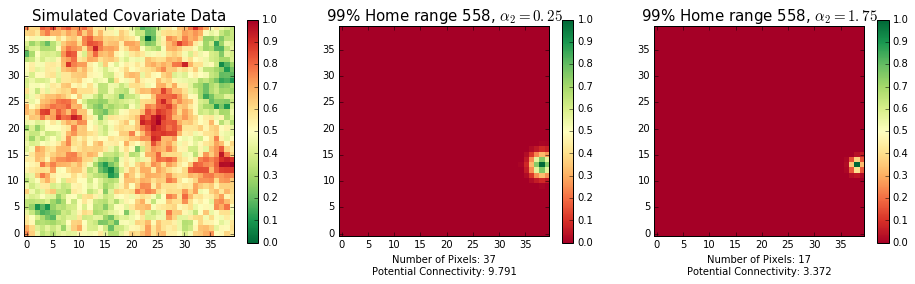

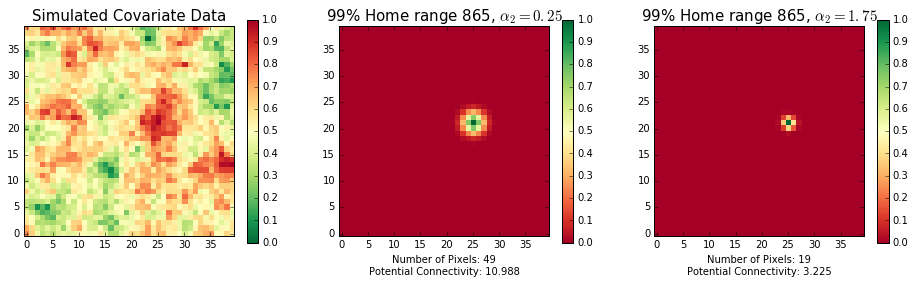

In [4]:
acs = [496, 1154, 558, 865]
for ac in acs:
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.imshow(covariatesurface, interpolation='nearest', cmap=cm.RdYlGn_r, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title('Simulated Covariate Data', fontsize=15)
    
    plt.subplot(1,3,2)
    hrac = useprobs[0.25][ac,]
    low = hrac < 0.01
    hrac[low] = 0
    plt.imshow(hrac.reshape(40,40), interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'99%% Home range %s, $\alpha_2=0.25$'%(ac), fontsize=15)
    plt.xlabel("Number of Pixels: %s\nPotential Connectivity: %s"%((hrac!=0).sum(), round(sum(hrac),3)))
    
    plt.subplot(1,3,3)
    hrac = useprobs[1.75][ac,]
    low = hrac < 0.01
    hrac[low] = 0
    plt.imshow(hrac.reshape(40,40), interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'99%% Home range %s, $\alpha_2=1.75$'%(ac), fontsize=15)
    plt.xlabel("Number of Pixels: %s\nPotential Connectivity: %s"%((hrac!=0).sum(), round(sum(hrac),3)))
plt.show()

The effect of the parameter settings on the use probabilities (and subsequently the potential connectivity) with increasing ecological distance is shown below:

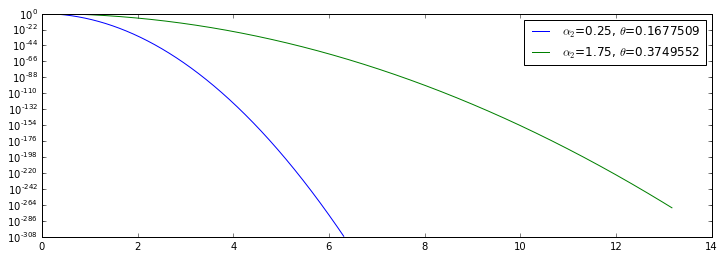

In [5]:
plt.figure(figsize=(12,4))
decol_list = dict()
# useprobs_list = dict()
for a2idx in range(len(alpha2)):
    decol_list[alpha2[a2idx]] = []
#     useprobs_list[alpha2[a2idx]] = []
    for i in range(npix):
        for j in range(npix):
            decol_list[alpha2[a2idx]].append(decol[alpha2[a2idx]][i][j])
#             useprobs_list[alpha2[a2idx]].append(useprobs[alpha2[a2idx]][i][j])
    decolscale = sorted(np.unique(decol_list[alpha2[a2idx]]))
    useprobscale = []
#     decolvals = sorted(decol_list[alpha2[a2idx]])
#     useprobsvals = sorted(useprobs_list[alpha2[a2idx]])
    for d in decolscale:
        useprobscale.append((math.exp(-(d*d)))**(1/(2*effsig[a2idx]*effsig[a2idx])))
#     plt.subplot(1,2,1)
    plt.semilogy(decolscale, useprobscale)
#     plt.subplot(1,2,2)
#     plt.semilogx(decolvals)
plt.legend([r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[0],effsig[0]), r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[1],effsig[1])])
plt.show()

For any value for ecological distance, the use probability is higher for the $\alpha_2=1.75$ case than for the $\alpha_2=0.25$ case. So ecological distances are on average smaller and less varying, but the use probability under a given ecological distance is lower, so that the potential connectivities will also be less varying and smaller. Conversely for $\alpha_2=1.75$, the ecological distances are on average larger and have a large variance, and the use probabilty under a given ecological distance is higher, so potential connectivities are on average higher and vary greatly. Comparing the distributions of pixel-wise potential connectivities $C^P(i)$:

a2: 0.25   theta: 0.1677509   min pc: 5.226   max pc: 15.539   mean pc: 12.645   total pc: 20232.795
a2: 1.75   theta: 0.3749552   min pc: 2.546   max pc: 32.416   mean pc: 13.972   total pc: 22354.55


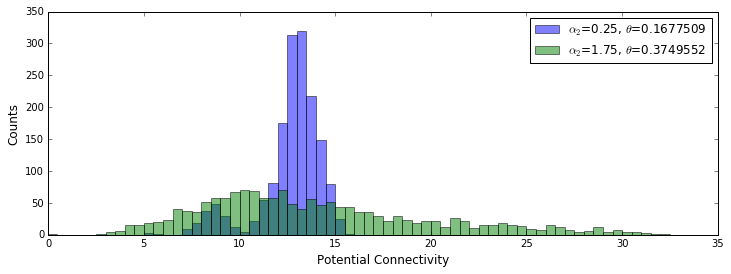

In [6]:
pcvals025 = pc[0.25].reshape(1600,1)
pcvals175 = pc[1.75].reshape(1600,1)
bin_boundaries = np.linspace(0,35,71)
# print(bin_boundaries)
print("a2: %s   theta: %s   min pc: %s   max pc: %s   mean pc: %s   total pc: %s"%(alpha2[0], effsig[0], round(min(pcvals025)[0],3), round(max(pcvals025)[0],3), round(np.mean(pcvals025),3), round(np.sum(pcvals025),3)))
print("a2: %s   theta: %s   min pc: %s   max pc: %s   mean pc: %s   total pc: %s"%(alpha2[1], effsig[1], round(min(pcvals175)[0],3), round(max(pcvals175)[0],3), round(np.mean(pcvals175),3), round(np.sum(pcvals175),3)))
plt.figure(figsize=(12,4))
n, bins, patches = plt.hist(pcvals025, bins=bin_boundaries, alpha=0.5)
n, bins, patches = plt.hist(pcvals175, bins=bin_boundaries, alpha=0.5)
plt.ylabel('Counts', fontsize=12)
plt.xlabel('Potential Connectivity', fontsize=12)
plt.legend([r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[0],effsig[0]), r'$\alpha_2$=%s, $\theta$=%s'%(alpha2[1],effsig[1])])
plt.show()

The higher potential connectivity in the $\alpha_2=1.75$ case suggests that the willingness of the animals to travel greater ecological distances ($\color{blue}{\alpha_1}$) overpowers the increased perceived ecological distance caused by the covariate surface ($\color{red}{\alpha_2}$). In a real case study, there is only one value of $\alpha_2$ for the species and only one corresponding $\alpha_1$ value. However, if we want to compare landscape reserve design for animals whose movement is either strongly or weakly linked to the covariate surface, i.e. treating $\alpha_2$ as the (only) resistance parameter, this "willingness" caused by $\alpha_1$ may be a confounding factor.

It may be interesting to separate the effects of $\alpha_2$ (sensitivity to covariate) and $\alpha_1$ (sensitivity to ecological distance). In particular, home ranges in low-resistance areas have very large home range areas under the $\alpha_2=1.75$ condition and correspondingly high potential connectivities. Since these are the most valuable to conserve when maximizing potential connectivity, it will appear as if better potential connectivity is achievable for the high resistance surface, although this is actually more due to the reduced sensitivity to ecological distance than due to the selection of pixels that facilitate animal movement. One possibility could be to examine why the mean home range size is (slightly) larger for $\alpha_2=1.75$ (since it is supposed to be the same by choice of effective sigma) and see if correcting for this will help reduce the overall potential connectivity.

## Sanity Checks

Max pc, recomputed: 15.5388727752
Max pc, data: 15.0203015382


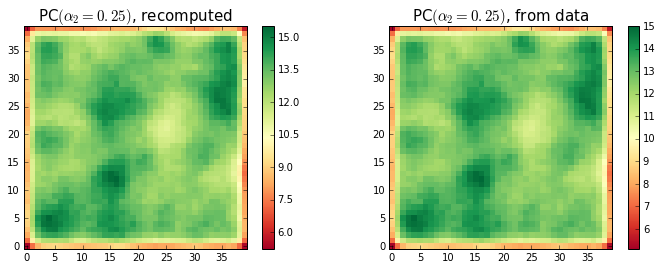

In [7]:
# Sanity check part 1
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pc[0.25].reshape(40,40), interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
print("Max pc, recomputed: %s"%pc[0.25].max())
plt.colorbar()
plt.grid(False)
plt.title(r'PC$(\alpha_2=0.25)$, recomputed', fontsize=15)
# plt.show()
datasetfilename = "../../Desktop/hropt/Data/simcov_a2025_S100_pc.tif"
with rasterio.open(datasetfilename) as src:
    r = src.read()
    data = r.squeeze()
    print("Max pc, data: %s"%data.max())
    data = np.transpose(data)
#     plt.figure(figsize=(5, 4))
    plt.subplot(1,2,2)
    plt.imshow(data, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'PC$(\alpha_2=0.25)$, from data', fontsize=15)
    plt.show()

Max pc, recomputed: 32.4155134426
Max pc, data: 32.6987691947


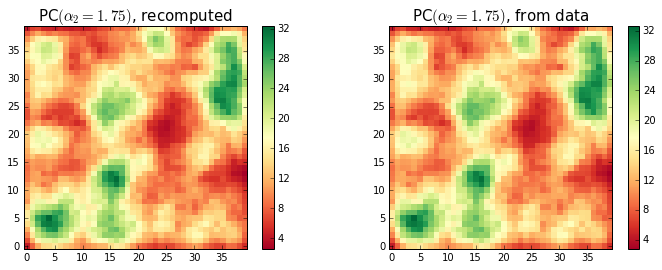

In [8]:
# Sanity check part 2
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.imshow(pc[1.75].reshape(40,40), interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
print("Max pc, recomputed: %s"%pc[1.75].max())
plt.colorbar()
plt.grid(False)
plt.title(r'PC$(\alpha_2=1.75)$, recomputed', fontsize=15)
# plt.show()
datasetfilename = "../../Desktop/hropt/Data/simcov_a2175_S100_pc.tif"
with rasterio.open(datasetfilename) as src:
    r = src.read()
    data = r.squeeze()
    print("Max pc, data: %s"%data.max())
    data = np.transpose(data)
#     plt.figure(figsize=(5, 4))
    plt.subplot(1,2,2)
    plt.imshow(data, interpolation='nearest', cmap=cm.RdYlGn, alpha=1.0, origin="lower") # interpolation can be nearest, bilinear, bicubic
    plt.colorbar()
    plt.grid(False)
    plt.title(r'PC$(\alpha_2=1.75)$, from data', fontsize=15)
    plt.show()